# 빅데이터처리
## Week08_Quiz
### 2016003709 윤가영

In [1]:
# To find out where the pyspark
import findspark
findspark.init()

In [2]:
# Creating Spark Context
from pyspark import SparkContext
sc = SparkContext("local", "first app")

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import math
import time
import copy

In [4]:
from scipy.stats import multivariate_normal as mvn

In [34]:
def create_dataset(N, D=2, K=None):
    if K is None:
        K = math.ceil(math.sqrt(N)/2)
        
    def create_normal_dist(n):
        mu = np.random.randint(-100, 100, size=(D,)) / 100. * D
        
        L = np.random.randint(-70, 70, size=(D,D)) / 100.
        cov = np.dot(L, L.transpose())
        
        t = np.random.multivariate_normal(mu, cov, n)
        return t
    
    dataset = list()
    Csize = int(N / K)
    for k in range(K):
        dataset_c = np.zeros((Csize, D+2))
        #gen IDs
        dataset_c[:, 1] = k
        dataset_c[:, 2:D+2] = create_normal_dist(Csize)
        dataset.extend(dataset_c)

    dataset = np.array(dataset)
    print(dataset.shape)
    dataset[:,0]= np.arange(K*Csize)
    
    return np.array(dataset)

#### cov 초기화 함수

In [6]:
def maker(idx, mean, point, num):
    total = []
    results = []
    
    for i in range(2):
        result = []
        for j in range(2):
            result.append((point[i] - mean[i])*(point[j] - mean[j]))
        results.append(result)
        
    total.append((idx,np.array(results)))
    return total

#### Gaussian pdf 생성 함수

In [38]:
def set_pdf(N, K, inputRDD, meanRDD, covRDD):
    P = [list(p[1][1]) for p in inputRDD]
    M = sc.parallelize(meanRDD).map(lambda x: list(x[1])).collect()
        
    Cv = []
    for co in covRDD:
        temp = []
        for x in co[1]:
            temp.append(list(x))
        Cv.append(temp)
    
    theta = []

    for i in range(K):
        try:
            pdf = mvn.pdf(P, mean=M[i], cov=Cv[i])
        except:
            pdf = mvn.pdf(P, mean=M[i], cov=Cv[i], allow_singular=True)
        
        for j in range(K*int(N/K)):
            if(pdf[j] < 1e-18):
                pdf[j] = 1e-18
                
        theta.append(pdf)
    
    return theta

#### 오차 확인 함수

In [40]:
def caculate_err(N, K, pdf, weight):
    sum_ = 0
    for i in range(K*int(N/K)):
        summ = 0
        for j in range(K):
            summ += weight[j] * pdf[j][i]
        summ = np.log(summ)
        sum_ += summ
    return sum_

#### E(Map) 함수

In [9]:
def E(pid, vector,theta, W, K):    
    result = []
    
    type1 = []
    type2 = []
    type3 = []
    
    sum_ = 0
    for i in range(K):
        sum_ += W[i] * theta[i][int(pid)]
    
    for i in range(K):
        # type1
        prob1 = (W[i] * theta[i][int(pid)]) / sum_
        type1.append(((i,1),prob1))
        
        # type2
        prob2 = [0 for i in range(2)]
        prob2[0] = prob1 * vector[0]
        prob2[1] = prob1 * vector[1]
        type2.append(((i,2),np.array(prob2)))
        
        # type3
        temp1 = []
        for j in range(2):
            temp2 = []
            for k in range(2): 
                prob3 = (vector[j] - prob2[j]) * (vector[k] - prob2[k]) * prob1
                temp2.append(prob3)
            temp1.append(temp2)
        
        type3.append(((i,3),np.array(temp1)))
    
    result.append(type1)
    result.append(type2)
    result.append(type3)

    return result

#### M 함수

In [10]:
def M(N, RDD1, RDD2, RDD3):
    bc_w = sc.broadcast(RDD1)
    weight = sc.parallelize(RDD1).mapValues(lambda x: x/N).map(lambda x: x[1]).collect()
    
    mean = sc.parallelize(RDD2).map(lambda x: (x[0][0], x[1] / bc_w.value[x[0][0]][1])).collect()
    
    cov = sc.parallelize(RDD3).map(lambda x: (x[0][0], x[1] / bc_w.value[x[0][0]][1])).collect()
    
    return weight, mean, cov

#### Quiz 해답

In [27]:
def Quiz(N, cluster=[10,20,40,80], convergenceTol=0.001, maxIter=50):
    duration = []
    result = []
    
    for k in cluster:
        dataset = create_dataset(N, K=k)
        
        start = time.time()
        
        inputRDD = sc.parallelize(dataset).map(lambda x: (x[0],(x[1],x[2:]))).cache()
        
        weight = [1. / float(k) for _ in range(k)]

        mean = inputRDD.map(lambda s: (s[1][0], (1, s[1][1]))).reduceByKey(lambda x,y : ((x[0]+y[0]), x[1]+y[1]))
        c_num = sc.broadcast(mean.map(lambda x: x[1][0]).collect())
        mean = mean.mapValues(lambda v: v[1]/v[0]).collect()
        bc_mean = sc.broadcast(mean)
        
        covariance = inputRDD.flatMap(lambda x: maker(x[1][0], bc_mean.value[int(x[1][0])][1], x[1][1], c_num.value[int(x[1][0])])).reduceByKey(lambda x,y: x + y).map(lambda x: (x[0],x[1]/c_num.value[int(x[0])])).collect()
        bc_covariance = sc.broadcast(covariance)
        
        pdf = set_pdf(N, k, inputRDD.collect(), mean, covariance)

        prev = caculate_err(N, k, pdf, weight)
        
        for itr in range(maxIter):
            RDD = inputRDD.flatMap(lambda x: E(x[0], x[1][1], pdf, weight, k)).flatMap(lambda x: x).reduceByKey(lambda x,y: x + y).collect()
            weight, mean, covariance = M(N, RDD[0:k], RDD[k:2*k], RDD[2*k:3*k]) 

            pdf = set_pdf(N, k, inputRDD.collect(), mean, covariance)

            # test convergence
            err = caculate_err(N, k, pdf, weight)
            print(itr)
            print((abs(err - prev) / abs(err)))
            if (abs(err - prev) / abs(err)) <= convergenceTol:
                prev = err
                break
 
            # save prev-error value
            prev = err
        
        end = time.time()
        
        result.append(weight)
        result.append(mean)
        result.append(covariance)
        duration.append(end-start)
        
    return duration    

#### Quiz 실행코드

In [28]:
X = [1000, 2000, 4000, 8000, 16000]

In [41]:
durations = []

for x in X:
    print("[Dataset: {}]".format(x))
    print()

    duration = Quiz(N=x)

    print("# of cluster : 10")
    print("Duration: {}".format(duration[0]))
    print()
    print("# of cluster : 20")
    print("Duration: {}".format(duration[1]))
    print()
    print("# of cluster : 40")
    print("Duration: {}".format(duration[2]))
    print()
    print("# of cluster : 80")
    print("Duration: {}".format(duration[3]))
    print()
    print("================================")
    print()

    durations.append(duration)

[Dataset: 1000]

(1000, 4)
0
0.4077463809791731
1
0.15921993129597553
2
0.3292948124444851
3
0.2725261972233435
4
0.038284783795734044
5
0.05710782041665836
6
0.09584485219808142
7
0.49026554489641827
8
1.298278310097767
9
0.32560326015814844
10
0.23486605404569336
11
0.6667461487742903
12
0.3569786314643804
13
0.2786485046281523
14
0.20105622802447654
15
0.25315569116147907
16
0.33393746708349903
17
0.7558364438596206
18
0.10444916425458067
19
0.33599388757836707
20
0.5563090189043849
21
0.3930820180681024
22
0.7825184619036178
23
0.19256654925003958
24
0.06611753525924331
25
0.018875583893219732
26
0.16094604273970536
27
0.43257951143347556
28
0.5921207295113661
29
2.1303783995067342
30
0.07465464826361418
31
0.47252699717396063
32
0.363665794926368
33
0.29132231597122343
34
0.6140389320262839
35
0.008586350267470524
36
0.30465463685704913
37
0.524346891944151
38
0.2488413012580758
39
0.07082523842805104
40
0.08633767314369883
41
0.1102688117868933
42
0.245948837759203
43
0.067056072

#### 그래프

In [42]:
th = [10, 20, 40, 80]
marker = ['^', 's', 'h', 'o']

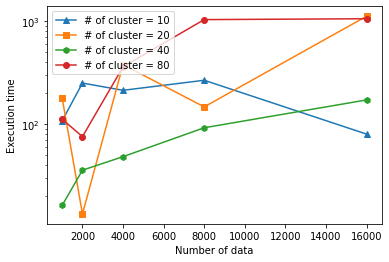

In [43]:
for i in range(4):
    result = []
    for j in range(5):
        result.append(durations[j][i])
    
    plt.plot(X, result, marker=marker[i], label="# of cluster = {}".format(th[i]))


plt.xlabel("Number of data")
plt.ylabel("Execution time")

plt.yscale('log')
plt.legend(loc='upper left', fontsize=10)

plt.show()